In [1]:
import os
import netCDF4 as nc4
import numpy as np
import matplotlib.pyplot as plt
from pysgrid import SGrid  # most current source at https://github.com/ayan-usgs/pysgrid
from pysgrid.processing_2d import vector_sum, rotate_vectors, avg_to_cell_center

In [2]:
SGRID_URL = 'http://geoport.whoi.edu/thredds/dodsC/coawst_4/use/fmrc/coawst_4_use_best.ncd'
TIME_SLICE = -1  # get the last time slice
VERTICAL_SLICE = -1  # get the last vertical slice
SUB = 1
SCALE = 0.06


In [3]:
os.environ['TCL_LIBRARY'] = 'C:/Python279/tcl/tcl8.5'
os.environ['TK_LIBRARY'] = 'C:/Python279/tcl/tk8.5'

In [4]:
def determine_avg_axis(array_shape, dim_0_max, dim_1_max):
    """
    Figure out which axis to average over for this
    dataset.
    
    """
    try:
        avg_axis = array_shape.index(dim_0_max)
    except ValueError:
        avg_axis = array_shape.index(dim_1_max)
    return avg_axis

In [5]:
%matplotlib inline

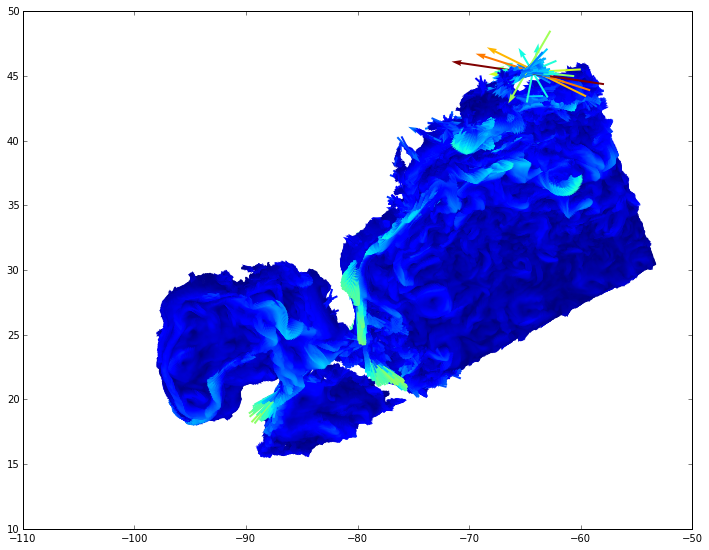

In [7]:
coawst = nc4.Dataset(SGRID_URL)
sgc = SGrid.from_nc_dataset(coawst)
grid_cell_centers = sgc.centers
grid_center_lon = grid_cell_centers[:, :, 0]
grid_center_lat = grid_cell_centers[:, :, 1]
u_slice = np.s_[TIME_SLICE, VERTICAL_SLICE] + sgc.u_slice[2:]  # include the time and vertical slice indices
u_trim = coawst.variables['u'][u_slice]
v_slice = np.s_[TIME_SLICE, VERTICAL_SLICE] + sgc.v_slice[2:]
v_trim = coawst.variables['v'][v_slice]
# angle_trim = coawst.variables['angle'][1:-1, 1:-1]  # rows and columns
angle_trim = coawst.variables['angle'][sgc.angle_slice]
# start figuring out what direction the vectors go in so they can be averaged to center
u_trim_shape = u_trim.shape
v_trim_shape = v_trim.shape
uv_dim_0 = (u_trim_shape[0], v_trim_shape[0])
uv_dim_1 = (u_trim_shape[1], v_trim_shape[1])
dim_0_max = max(uv_dim_0)
dim_1_max = max(uv_dim_1)
u_avg_dim = determine_avg_axis(u_trim_shape, dim_0_max, dim_1_max)
v_avg_dim = determine_avg_axis(v_trim_shape, dim_0_max, dim_1_max)
# end figuring out what direction the vectors go in so they can be averaged to center
u_avg = avg_to_cell_center(u_trim, u_avg_dim)  # velocity in x-direction (I think...)
v_avg = avg_to_cell_center(v_trim, v_avg_dim)  # y-direction
u_rot, v_rot = rotate_vectors(u_avg, v_avg, angle_trim)
lon_rho = grid_center_lon[sgc.lon_rho_slice]
lat_rho = grid_center_lat[sgc.lat_rho_slice]
uv_sum = vector_sum(u_rot, v_rot)
fig = plt.figure(figsize=(12, 12))
plt.subplot(111, aspect=(1.0/np.cos(np.mean(lat_rho)*np.pi/180.0)))
q = plt.quiver(lon_rho[::SUB, ::SUB], 
               lat_rho[::SUB, ::SUB], 
               u_rot[::SUB, ::SUB], 
               v_rot[::SUB, ::SUB],
               uv_sum[::SUB, ::SUB],
               scale=1.0/SCALE, 
               pivot='middle', 
               zorder=1e35, 
               width=0.003
              )
plt.quiverkey(q, 0.85, 0.07, 1.0, label=r'1 m s$^{-1}$', coordinates='figure')